# Titanic: Machine Learning from Disaster

Author: Bruno Maciel Machado

In [1054]:
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from collections import Counter
from scipy import stats
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [1055]:
# Importing the data
training_set = pd.read_csv('Data/train.csv')
test_set = pd.read_csv('Data/test.csv')
training_set_manipulation = training_set
test_set_manipulation = test_set

In [1056]:
# Taking a look on the features
training_set_manipulation

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Data Analysis and Preprocessing

In order to extract the best of our Machine Learning models, it's necessary to clean, fill and understand the given data.



First, let's check if there's any missing value and if so, handle them:

I will assume that the following features aren't related to the survival of a titanic passenger:
- Passenger Id
- Ticket
- Cabin

Therefore, these features will be dropped.

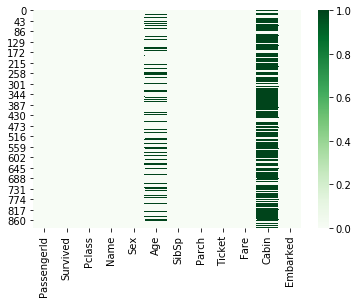

In [1057]:
sns.heatmap(training_set_manipulation.isnull(),cmap="Greens")

There are a lot of missing values in the Cabin and Age feature.
- The missing ages will be filled with the median value of ages
- The missing cabin values will be simply dropped as the whole feature column

In [1058]:
training_set_manipulation = training_set_manipulation.drop(labels=['PassengerId','Ticket','Cabin'], axis=1)
test_set_manipulation = test_set_manipulation.drop(labels=['PassengerId','Ticket','Cabin'], axis=1)

In [1059]:
training_set_manipulation['Age'].fillna(training_set_manipulation['Age'].median(), inplace=True)
test_set_manipulation['Age'].fillna(test_set_manipulation['Age'].median(), inplace=True)
test_set_manipulation['Fare'].fillna(test_set_manipulation['Fare'].median(), inplace=True)

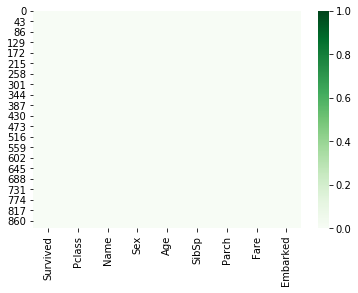

In [1060]:
# Verifying that no missing value is left
sns.heatmap(training_set_manipulation.isnull(),cmap="Greens")

In order to have a better suited representation of this analysis' population, we have to take a look and make decisions about the handling of possibles outliers.

We will analyze the outliers of three features:
- Fare
- Age
- SipSp

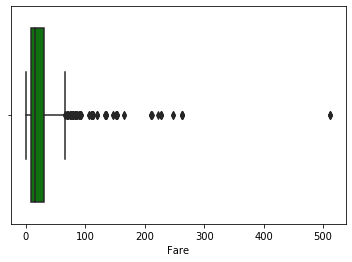

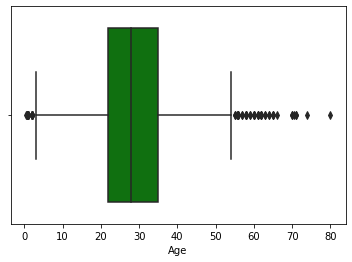

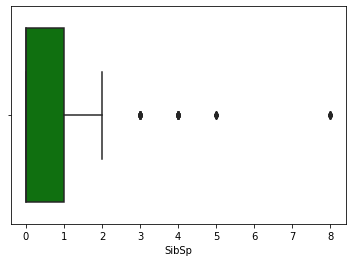

In [1061]:
sns.boxplot(x=training_set_manipulation['Fare'], color='green')
plt.figure()
sns.boxplot(x=training_set_manipulation['Age'], color='green')
plt.figure()
sns.boxplot(x=training_set_manipulation['SibSp'], color='green')

In [1062]:
k = (np.array(training_set_manipulation['Fare']).flatten())
np.sort(k)

array([  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   4.0125,   5.    ,   6.2375,
         6.4375,   6.45  ,   6.4958,   6.4958,   6.75  ,   6.75  ,
         6.8583,   6.95  ,   6.975 ,   6.975 ,   7.0458,   7.05  ,
         7.05  ,   7.05  ,   7.05  ,   7.05  ,   7.05  ,   7.05  ,
         7.0542,   7.0542,   7.125 ,   7.125 ,   7.125 ,   7.125 ,
         7.1417,   7.225 ,   7.225 ,   7.225 ,   7.225 ,   7.225 ,
         7.225 ,   7.225 ,   7.225 ,   7.225 ,   7.225 ,   7.225 ,
         7.225 ,   7.2292,   7.2292,   7.2292,   7.2292,   7.2292,
         7.2292,   7.2292,   7.2292,   7.2292,   7.2292,   7.2292,
         7.2292,   7.2292,   7.2292,   7.2292,   7.25  ,   7.25  ,
         7.25  ,   7.25  ,   7.25  ,   7.25  ,   7.25  ,   7.25  ,
         7.25  ,   7.25  ,   7.25  ,   7.25  ,   7.25  ,   7.3125,
         7.4958,   7.4958,   7.4958,   7.5208,   7.55  ,   7.5

Analyzing these three features and their outliers we can see that they are probably authentic values, i.e., they are not due to erroneous information. 

By the way, we can take a look on these abnormal values. Therefore, the three samples which payed a ticket fare higher than 300 units have survived. This information sums up to the intuition that those who payed more on the ticket had a higher chance to survive.

The four out of the five passangers who aged more 70 years did not survived the crash, which sums up to the idea that the elders were less prone to survive.

Therefore, I've analyzed the population's outliers nad I've decided to not erase them.

In [1063]:
# We will simply cut samples which have a ticket fare higher than 300
Fare_outlier = np.where(training_set_manipulation['Fare'] > 300);

In [1064]:
# Samples to be cut
training_set_manipulation.loc[Fare_outlier]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
258,1,1,"Ward, Miss. Anna",female,35.0,0,0,512.3292,C
679,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,512.3292,C
737,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,512.3292,C


In [1065]:
#training_set_manipulation = training_set_manipulation.drop(training_set_manipulation.index[Fare_outlier])

In [1066]:
training_set_manipulation

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,23.4500,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C


In [1067]:
Age_outlier = np.where(training_set_manipulation['Age'] > 70);
training_set_manipulation.loc[Age_outlier]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
96,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,34.6542,C
116,0,3,"Connors, Mr. Patrick",male,70.5,0,0,7.7500,Q
493,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,49.5042,C
630,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,30.0000,S
851,0,3,"Svensson, Mr. Johan",male,74.0,0,0,7.7750,S


In [1068]:
#training_set_manipulation = training_set_manipulation.drop(training_set_manipulation.index[Age_outlier])

In [1069]:
training_set_manipulation

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,23.4500,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C


## Relation between each feature and the passenger's survival

- Age: One can observe that babies and very young children are more prone to survive, while elders have a I higher chance to die.

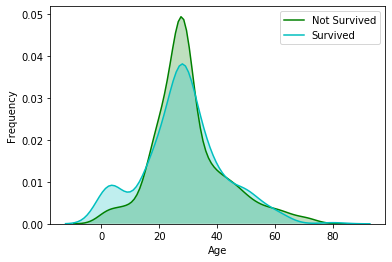

In [1070]:
frequency = sns.kdeplot(training_set_manipulation["Age"][(training_set_manipulation["Survived"] == 0) & (training_set_manipulation["Age"].notnull())], color="Green", shade = True)
frequency = sns.kdeplot(training_set_manipulation["Age"][(training_set_manipulation["Survived"] == 1) & (training_set_manipulation["Age"].notnull())], ax =frequency, color="c", shade= True)
frequency.set_xlabel("Age")
frequency.set_ylabel("Frequency")
frequency = frequency.legend(["Not Survived","Survived"])

- Parent/Children & Sibling/Spouse: One can verify that the size of the family has some relation to the survival of its individuals.

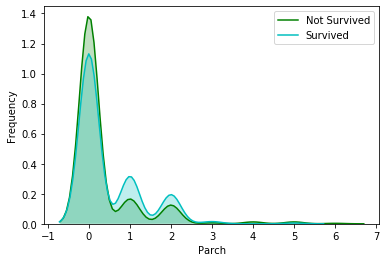

In [1071]:
frequency = sns.kdeplot(training_set_manipulation["Parch"][(training_set_manipulation["Survived"] == 0) & (training_set_manipulation["Parch"].notnull())], color="Green", shade = True)
frequency = sns.kdeplot(training_set_manipulation["Parch"][(training_set_manipulation["Survived"] == 1) & (training_set_manipulation["Parch"].notnull())], ax =frequency, color="c", shade= True)
frequency.set_xlabel("Parch")
frequency.set_ylabel("Frequency")
frequency = frequency.legend(["Not Survived","Survived"])

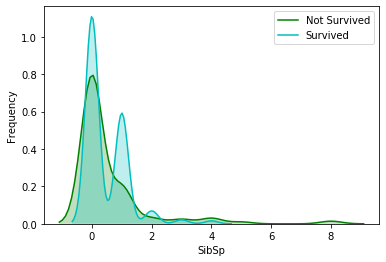

In [1072]:
frequency_sib = sns.kdeplot(training_set_manipulation["SibSp"][(training_set_manipulation["Survived"] == 0) & (training_set_manipulation["SibSp"].notnull())], color="Green", shade = True)
frequency_sib = sns.kdeplot(training_set_manipulation["SibSp"][(training_set_manipulation["Survived"] == 1) & (training_set_manipulation["SibSp"].notnull())], ax =frequency_sib, color="c", shade= True)
frequency_sib.set_xlabel("SibSp")
frequency_sib.set_ylabel("Frequency")
frequency_sib = frequency_sib.legend(["Not Survived","Survived"])

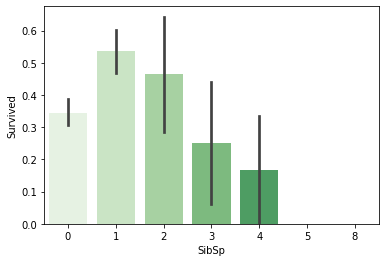

In [1073]:
sns.barplot(training_set_manipulation['SibSp'], training_set_manipulation['Survived'], palette='Greens')

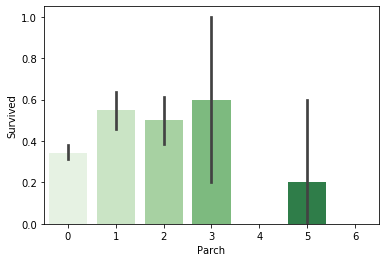

In [1074]:
sns.barplot(training_set_manipulation['Parch'], training_set_manipulation['Survived'], palette='Greens')

As one can see, these both features are strongly correlated. In order to take advantage of this fact, a new feature is introduced, FamilySize, which is the sum of the SibSp and Parch, giving the size of the family of each sample. Therefore, it is visible that the pessanger's family size has a relation to his survival. It was created too a second new feature which indicates if the passanger was alone or not.

In [1075]:
training_set_manipulation['FamilySize'] = training_set_manipulation['SibSp'] + training_set_manipulation['Parch'] + 1
test_set_manipulation['FamilySize'] = test_set_manipulation['SibSp'] + test_set_manipulation['Parch'] + 1

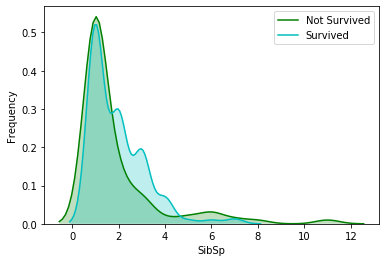

In [1076]:
# Explore Age distibution 
g = sns.kdeplot(training_set_manipulation["FamilySize"][(training_set_manipulation["Survived"] == 0) & (training_set_manipulation["FamilySize"].notnull())], color="Green", shade = True)
g = sns.kdeplot(training_set_manipulation["FamilySize"][(training_set_manipulation["Survived"] == 1) & (training_set_manipulation["FamilySize"].notnull())], ax =g, color="c", shade= True)
g.set_xlabel("SibSp")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

In [1077]:
training_set_manipulation['FamilySize'].values.reshape(-1,1).shape

(891, 1)

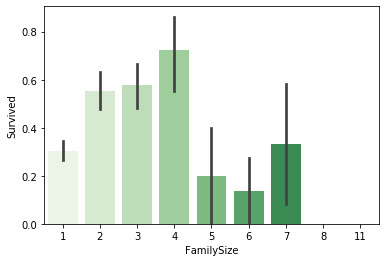

In [1078]:
sns.barplot(training_set_manipulation['FamilySize'], training_set_manipulation['Survived'], palette='Greens')

In [1079]:
training_set_manipulation['isAlone'] = (training_set_manipulation['FamilySize'].values < 2)
test_set_manipulation['isAlone'] = (test_set_manipulation['FamilySize'].values < 2)
training_set_manipulation

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,isAlone
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,False
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,False
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,True
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,False
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,True
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S,1,True
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S,1,True
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,23.4500,S,4,False
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C,1,True


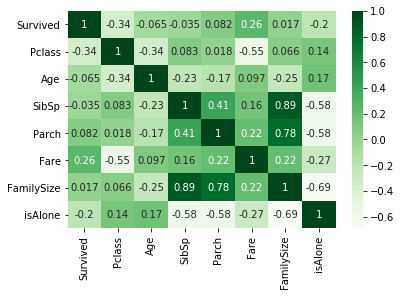

In [1080]:
sns.heatmap(training_set_manipulation.corr(), annot=True, cmap='Greens')

We can see that the Fare is high correlation to the survival of each passenger. The ticket class (Pclass) has a high inverse relation to the continuance of the passenger's live.

- Fare/Pclass: The passengers belonging to the first class and consequently those who payed more for the ticked have a higher chance to survive. One can see that these features are strongly inversely proportional. Therefore, the idea of relating these two features comes up.

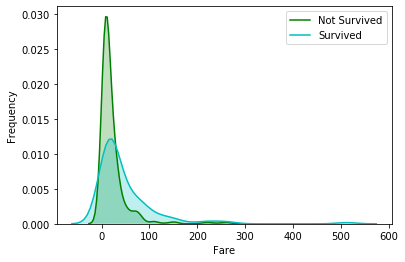

In [1081]:
# Explore Age distibution 
g = sns.kdeplot(training_set_manipulation["Fare"][(training_set_manipulation["Survived"] == 0) & (training_set_manipulation["Fare"].notnull())], color="Green", shade = True)
g = sns.kdeplot(training_set_manipulation["Fare"][(training_set_manipulation["Survived"] == 1) & (training_set_manipulation["Fare"].notnull())], ax =g, color="c", shade= True)
g.set_xlabel("Fare")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

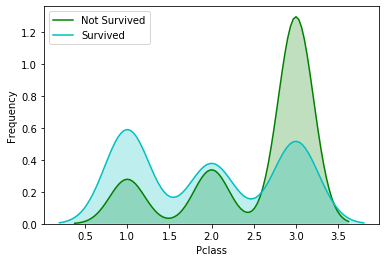

In [1082]:
g = sns.kdeplot(training_set_manipulation["Pclass"][(training_set_manipulation["Survived"] == 0) & (training_set_manipulation["Pclass"].notnull())], color="Green", shade = True)
g = sns.kdeplot(training_set_manipulation["Pclass"][(training_set_manipulation["Survived"] == 1) & (training_set_manipulation["Pclass"].notnull())], ax =g, color="c", shade= True)
g.set_xlabel("Pclass")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

In [1083]:
training_set_manipulation['Money'] = training_set_manipulation['Fare'] / training_set_manipulation['Pclass']
test_set_manipulation['Money'] = test_set_manipulation['Fare'] / test_set_manipulation['Pclass']

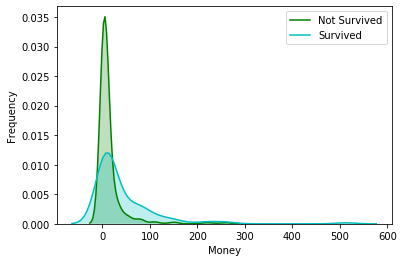

In [1084]:
# Explore Age distibution 
g = sns.kdeplot(training_set_manipulation["Money"][(training_set_manipulation["Survived"] == 0) & (training_set_manipulation["Money"].notnull())], color="Green", shade = True)
g = sns.kdeplot(training_set_manipulation["Money"][(training_set_manipulation["Survived"] == 1) & (training_set_manipulation["Money"].notnull())], ax =g, color="c", shade= True)
g.set_xlabel("Money")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

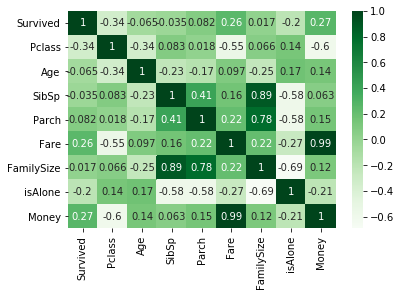

In [1085]:
sns.heatmap(training_set_manipulation.corr(), annot=True, cmap='Greens')

As we can see the economic class of the passenger has a lot to do with its survival in relation to the Titanic Disaster. Therefore, let's verify if the existance of honorofics has some relation to the survival at the Titanic sinking.

In [1086]:
honorific = []
for row in training_set_manipulation['Name']:

    result = [x.strip() for x in row.split(',')]
    result = [x.strip() for x in result[1].split(' ')]
    if result[0] in ['Mr.','Master.','Miss.','Mrs.','Ms.']:
        honorific = np.append(honorific,"-")
    else:
        honorific = np.append(honorific,result[0])
specialHonorifics = [value for value in honorific if value != '-']       
specialHonorifics_set = set(specialHonorifics)
print("{}{}".format("These are the special honorifics found in the data: ",specialHonorifics_set))

These are the special honorifics found in the data: {'Mlle.', 'Rev.', 'Sir.', 'the', 'Col.', 'Don.', 'Dr.', 'Mme.', 'Capt.', 'Jonkheer.', 'Major.', 'Lady.'}


In [1087]:
training_set_manipulation['SpecialName'] = [ int(value) for value in honorific != '-']

We can see that the existance of special honorifics has nothing to do with the survivance of a passenger, as shown in the plot and heatmap below.

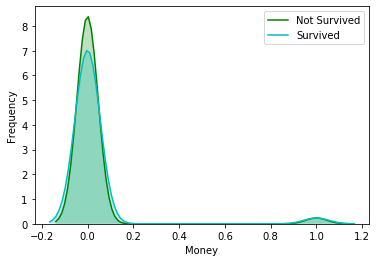

In [1088]:
# Explore Age distibution 
g = sns.kdeplot(training_set_manipulation["SpecialName"][(training_set_manipulation["Survived"] == 0) & (training_set_manipulation["SpecialName"].notnull())], color="Green", shade = True)
g = sns.kdeplot(training_set_manipulation["SpecialName"][(training_set_manipulation["Survived"] == 1) & (training_set_manipulation["SpecialName"].notnull())], ax =g, color="c", shade= True)
g.set_xlabel("Money")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

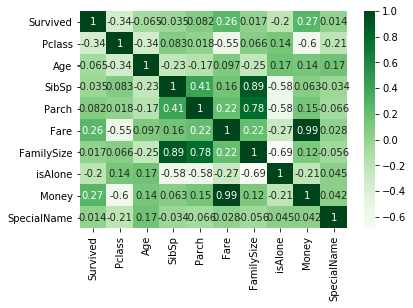

In [1089]:
sns.heatmap(training_set_manipulation.corr(), annot=True, cmap='Greens')

But if we analyze only the femine honorifcs, we can extract a lot of informations and we can see a good correlation to one's survivance.

In [1090]:
honorific = []
for row in training_set_manipulation['Name']:

    result = [x.strip() for x in row.split(',')]
    result = [x.strip() for x in result[1].split(' ')]
    if result[0] in ['Mr.','Master.','Sir.','Jonkheer.','Col.','the','Dr','Rev.','Capt.', 'Major.', 'Don.']:
        honorific = np.append(honorific,"-")
    else:
        honorific = np.append(honorific,result[0])

In [1091]:
training_set_manipulation['SpecialName'] = [ int(value) for value in honorific != '-']

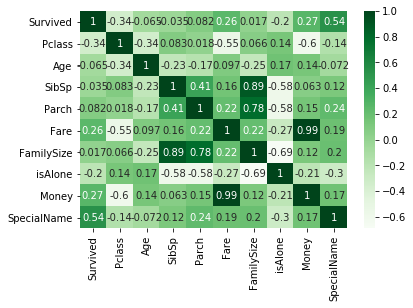

In [1092]:
sns.heatmap(training_set_manipulation.corr(), annot=True, cmap='Greens')

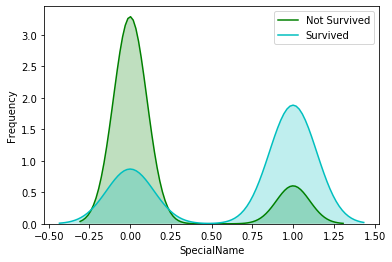

In [1093]:
g = sns.kdeplot(training_set_manipulation["SpecialName"][(training_set_manipulation["Survived"] == 0) & (training_set_manipulation["SpecialName"].notnull())], color="Green", shade = True)
g = sns.kdeplot(training_set_manipulation["SpecialName"][(training_set_manipulation["Survived"] == 1) & (training_set_manipulation["SpecialName"].notnull())], ax =g, color="c", shade= True)
g.set_xlabel("SpecialName")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

In [1094]:
training_set_manipulation

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,isAlone,Money,SpecialName
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,False,2.416667,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,False,71.283300,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,True,2.641667,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,False,53.100000,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,True,2.683333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S,1,True,6.500000,0
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S,1,True,30.000000,1
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,23.4500,S,4,False,7.816667,1
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C,1,True,30.000000,0


Now that we've extracted some informations from the passenger's name, I have decided to drop the Name feature.

In [1095]:
test_set_manipulation = test_set_manipulation.drop(labels=['Name'], axis=1)
training_set_manipulation = training_set_manipulation.drop(labels=['Name'], axis=1)

Now I discretize the age, fare and money in different bins.

In [1096]:
training_set_manipulation['FareBin'] = pd.qcut(training_set_manipulation['Fare'], 4)
test_set_manipulation['FareBin'] = pd.qcut(test_set_manipulation['Fare'], 4)
training_set_manipulation['AgeBin'] = pd.cut(training_set_manipulation['Age'].astype(int), 5)
test_set_manipulation['AgeBin'] = pd.cut(test_set_manipulation['Age'].astype(int), 5)
training_set_manipulation['MoneyBin'] = pd.cut(training_set_manipulation['Money'].astype(int), 4)
test_set_manipulation['MoneyBin'] = pd.cut(test_set_manipulation['Money'].astype(int), 4)
training_set_manipulation

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,isAlone,Money,SpecialName,FareBin,AgeBin,MoneyBin
0,0,3,male,22.0,1,0,7.2500,S,2,False,2.416667,0,"(-0.001, 7.91]","(16.0, 32.0]","(-0.512, 128.0]"
1,1,1,female,38.0,1,0,71.2833,C,2,False,71.283300,1,"(31.0, 512.329]","(32.0, 48.0]","(-0.512, 128.0]"
2,1,3,female,26.0,0,0,7.9250,S,1,True,2.641667,1,"(7.91, 14.454]","(16.0, 32.0]","(-0.512, 128.0]"
3,1,1,female,35.0,1,0,53.1000,S,2,False,53.100000,1,"(31.0, 512.329]","(32.0, 48.0]","(-0.512, 128.0]"
4,0,3,male,35.0,0,0,8.0500,S,1,True,2.683333,0,"(7.91, 14.454]","(32.0, 48.0]","(-0.512, 128.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,1,True,6.500000,0,"(7.91, 14.454]","(16.0, 32.0]","(-0.512, 128.0]"
887,1,1,female,19.0,0,0,30.0000,S,1,True,30.000000,1,"(14.454, 31.0]","(16.0, 32.0]","(-0.512, 128.0]"
888,0,3,female,28.0,1,2,23.4500,S,4,False,7.816667,1,"(14.454, 31.0]","(16.0, 32.0]","(-0.512, 128.0]"
889,1,1,male,26.0,0,0,30.0000,C,1,True,30.000000,0,"(14.454, 31.0]","(16.0, 32.0]","(-0.512, 128.0]"


I encode the categorical data

In [1097]:
oneHotEncoding = OneHotEncoder()
training_set_manipulation['Sex'] = oneHotEncoding.fit_transform(training_set_manipulation['Sex'].values.reshape(-1,1)).toarray()

In [1098]:
test_set_manipulation['Sex'] = oneHotEncoding.fit_transform(test_set_manipulation['Sex'].values.reshape(-1,1)).toarray()

In [1099]:
code,_ = pd.factorize(training_set_manipulation['Embarked'])
training_set_manipulation['Embarked'] = code

In [1100]:
code,_ = pd.factorize(test_set_manipulation['Embarked'])
test_set_manipulation['Embarked'] = code

In [1101]:
label = LabelEncoder()

In [1102]:
(test_set_manipulation['FareBin'])

0        (-0.001, 7.896]
1        (-0.001, 7.896]
2        (7.896, 14.454]
3        (7.896, 14.454]
4        (7.896, 14.454]
             ...        
413      (7.896, 14.454]
414    (31.472, 512.329]
415      (-0.001, 7.896]
416      (7.896, 14.454]
417     (14.454, 31.472]
Name: FareBin, Length: 418, dtype: category
Categories (4, interval[float64]): [(-0.001, 7.896] < (7.896, 14.454] < (14.454, 31.472] < (31.472, 512.329]]

In [1103]:
training_set_manipulation['AgeBin_Code'] = label.fit_transform(training_set_manipulation['AgeBin'])
training_set_manipulation['FareBin_Code'] = label.fit_transform(training_set_manipulation['FareBin'])
training_set_manipulation['MoneyBin_Code'] = label.fit_transform(training_set_manipulation['MoneyBin'])
test_set_manipulation['FareBin_Code'] = label.fit_transform(test_set_manipulation['FareBin'])
test_set_manipulation['AgeBin_Code'] = label.fit_transform(test_set_manipulation['AgeBin'])
test_set_manipulation['MoneyBin_Code'] = label.fit_transform(test_set_manipulation['MoneyBin'])

In [1104]:
label = LabelEncoder()

In [1105]:
test_set_manipulation.isnull().sum()

Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
isAlone          0
Money            0
FareBin          0
AgeBin           0
MoneyBin         0
FareBin_Code     0
AgeBin_Code      0
MoneyBin_Code    0
dtype: int64

In [1106]:
#test_set_manipulation['FareBin_Code'] = label.fit_transform(test_set_manipulation['FareBin'])

In [1107]:
type(test_set_manipulation['FareBin'][0])
type(training_set_manipulation['FareBin'][0])
type(test_set_manipulation['FareBin'][0])


pandas._libs.interval.Interval

In [1108]:
training_set_manipulation

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,isAlone,Money,SpecialName,FareBin,AgeBin,MoneyBin,AgeBin_Code,FareBin_Code,MoneyBin_Code
0,0,3,0.0,22.0,1,0,7.2500,0,2,False,2.416667,0,"(-0.001, 7.91]","(16.0, 32.0]","(-0.512, 128.0]",1,0,0
1,1,1,1.0,38.0,1,0,71.2833,1,2,False,71.283300,1,"(31.0, 512.329]","(32.0, 48.0]","(-0.512, 128.0]",2,3,0
2,1,3,1.0,26.0,0,0,7.9250,0,1,True,2.641667,1,"(7.91, 14.454]","(16.0, 32.0]","(-0.512, 128.0]",1,1,0
3,1,1,1.0,35.0,1,0,53.1000,0,2,False,53.100000,1,"(31.0, 512.329]","(32.0, 48.0]","(-0.512, 128.0]",2,3,0
4,0,3,0.0,35.0,0,0,8.0500,0,1,True,2.683333,0,"(7.91, 14.454]","(32.0, 48.0]","(-0.512, 128.0]",2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0.0,27.0,0,0,13.0000,0,1,True,6.500000,0,"(7.91, 14.454]","(16.0, 32.0]","(-0.512, 128.0]",1,1,0
887,1,1,1.0,19.0,0,0,30.0000,0,1,True,30.000000,1,"(14.454, 31.0]","(16.0, 32.0]","(-0.512, 128.0]",1,2,0
888,0,3,1.0,28.0,1,2,23.4500,0,4,False,7.816667,1,"(14.454, 31.0]","(16.0, 32.0]","(-0.512, 128.0]",1,2,0
889,1,1,0.0,26.0,0,0,30.0000,1,1,True,30.000000,0,"(14.454, 31.0]","(16.0, 32.0]","(-0.512, 128.0]",1,2,0


In [1109]:
training_set_manipulation = training_set_manipulation.drop(labels=['AgeBin','FareBin', 'MoneyBin'], axis=1)
training_set_manipulation

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,isAlone,Money,SpecialName,AgeBin_Code,FareBin_Code,MoneyBin_Code
0,0,3,0.0,22.0,1,0,7.2500,0,2,False,2.416667,0,1,0,0
1,1,1,1.0,38.0,1,0,71.2833,1,2,False,71.283300,1,2,3,0
2,1,3,1.0,26.0,0,0,7.9250,0,1,True,2.641667,1,1,1,0
3,1,1,1.0,35.0,1,0,53.1000,0,2,False,53.100000,1,2,3,0
4,0,3,0.0,35.0,0,0,8.0500,0,1,True,2.683333,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0.0,27.0,0,0,13.0000,0,1,True,6.500000,0,1,1,0
887,1,1,1.0,19.0,0,0,30.0000,0,1,True,30.000000,1,1,2,0
888,0,3,1.0,28.0,1,2,23.4500,0,4,False,7.816667,1,1,2,0
889,1,1,0.0,26.0,0,0,30.0000,1,1,True,30.000000,0,1,2,0


In [1110]:
training_set_manipulation = training_set_manipulation.drop(labels=['Fare','Age', 'Money'], axis=1)
training_set_manipulation

,Survived,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,isAlone,SpecialName,AgeBin_Code,FareBin_Code,MoneyBin_Code
0,0,3,0.0,1,0,0,2,False,0,1,0,0
1,1,1,1.0,1,0,1,2,False,1,2,3,0
2,1,3,1.0,0,0,0,1,True,1,1,1,0
3,1,1,1.0,1,0,0,2,False,1,2,3,0
4,0,3,0.0,0,0,0,1,True,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0.0,0,0,0,1,True,0,1,1,0
887,1,1,1.0,0,0,0,1,True,1,1,2,0
888,0,3,1.0,1,2,0,4,False,1,1,2,0
889,1,1,0.0,0,0,1,1,True,0,1,2,0


I normalize each sample and each feature.

In [1111]:
SC = StandardScaler()

In [1112]:
training_set_manipulation = pd.DataFrame(SC.fit_transform(training_set_manipulation),columns = training_set_manipulation.columns)

In [1113]:
training_set_manipulation

,Survived,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,isAlone,SpecialName,AgeBin_Code,FareBin_Code,MoneyBin_Code
0,-0.789272,0.827377,-0.737695,0.432793,-0.473674,-0.562619,0.059160,-1.231645,-0.746788,-0.355405,-1.339737,-0.190651
1,1.266990,-1.566107,1.355574,0.432793,-0.473674,1.003923,0.059160,-1.231645,1.339068,0.876757,1.344758,-0.190651
2,1.266990,0.827377,1.355574,-0.474545,-0.473674,-0.562619,-0.560975,0.811922,1.339068,-0.355405,-0.444905,-0.190651
3,1.266990,-1.566107,1.355574,0.432793,-0.473674,-0.562619,0.059160,-1.231645,1.339068,0.876757,1.344758,-0.190651
4,-0.789272,0.827377,-0.737695,-0.474545,-0.473674,-0.562619,-0.560975,0.811922,-0.746788,0.876757,-0.444905,-0.190651
...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.789272,-0.369365,-0.737695,-0.474545,-0.473674,-0.562619,-0.560975,0.811922,-0.746788,-0.355405,-0.444905,-0.190651
887,1.266990,-1.566107,1.355574,-0.474545,-0.473674,-0.562619,-0.560975,0.811922,1.339068,-0.355405,0.449927,-0.190651
888,-0.789272,0.827377,1.355574,0.432793,2.008933,-0.562619,1.299429,-1.231645,1.339068,-0.355405,0.449927,-0.190651
889,1.266990,-1.566107,-0.737695,-0.474545,-0.473674,1.003923,-0.560975,0.811922,-0.746788,-0.355405,0.449927,-0.190651


## Model
I have decided to use a logistic regression classifier. Using two hidden layers with dropout.

In [1114]:
def build_classifier():
    ann = Sequential()
    ann.add(Dense(units=512,
                  activation='relu',
                  kernel_initializer='uniform',
                  bias_initializer='uniform',
                  input_shape=(X_train_imputed.shape[1],)))
    ann.add(Dropout(rate=0.18))
    ann.add(Dense(units=512,
                  activation='relu',
                  kernel_initializer='uniform',
                  bias_initializer='uniform'))
    ann.add(Dropout(rate=0.18))
    ann.add(Dense(units=512,
                  activation='relu',
                  kernel_initializer='uniform',
                  bias_initializer='uniform'))
    ann.add(Dense(units=1,
                  activation='sigmoid',
                  kernel_initializer='uniform',
                  bias_initializer='uniform'))
    ann.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return ann

In [1115]:
monitor = EarlyStopping(monitor='accuracy', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

In [1116]:
classifier = KerasClassifier(build_fn=build_classifier,batch_size=800, epochs=1000)

In [1117]:
parameters = {'batch_size':[899],
              'epochs':[600]}

In [1118]:
grid_search = GridSearchCV(estimator = classifier,
                           param_grid= parameters,
                           scoring = 'accuracy',
                           cv = 10)

In [1119]:
y_train_imputed = training_set_manipulation['Survived']
X_train_imputed = training_set_manipulation.drop(labels=['Survived'], axis=1)

I am using a cross validation score with 15 folds.

In [ ]:
accuracies = cross_val_score(classifier,X_train_imputed, y_train_imputed, cv=15)

In [1121]:
print("{}{:.2f}{}".format('K-fold validation accuracy: ', accuracies.mean()*100,'%'))

K-fold validation accuracy: 81.27%
